In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_result
from analyze_tools import plot_tools as pt
import analyze_tools.monte_carlo as at

import animation as an

def assert_path(path):
    try: 
        assert os.path.isdir(path)
    except AssertionError:
        raise Exception("Path {} is not exist".format(path))

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

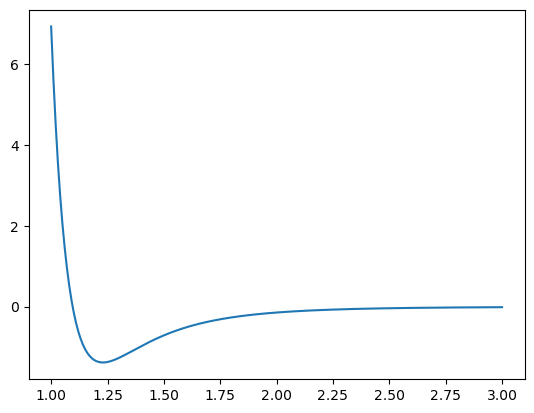

In [2]:
potential_func = lambda r: 4 * red.epsilon_Ar_Xe * ((red.sigma_Ar_Xe**12 / r**12) - (red.sigma_Ar_Xe**6 / r**6))

r = np.linspace(1,3,400)
fig,ax = plt.subplots()
ax.plot(r, potential_func(r))

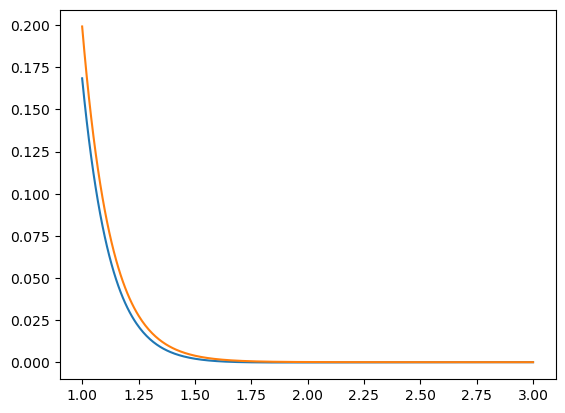

In [3]:
dipole_func = lambda d: red.mu0 * np.exp(-red.a * (d - red.d0)) - red.d7/d**7
dipole_func2 = lambda d: red.mu0 * np.exp(-red.a * (d - red.d0))# - red.d7/d**7

fig,ax = plt.subplots()
ax.plot(r, dipole_func(r))
ax.plot(r, dipole_func2(r))

In [36]:
ROOT2 = "pickle_jar/"

temperature_list = ['292.0', '200.0']#, 100]
seed_list = [157, 751, 198]
seed_list2 = [1,2]
c_list = ['Lxy1e1', "Lxy2e1"]

#nofield_path = lambda t,s: ROOT2 + "nofield-{}_256_{}".format(t,s)
freefield_path = lambda t,s: ROOT2 + "free-{}_256_{}-zero_0_0-c0".format(t,s)
cavityfield_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-zpve_0_0-c1_{}-microz".format(t,s,c)

for i, temp in enumerate(temperature_list):
    assert_path(freefield_path(temp, seed_list[i]))
    #assert_path(cavityfield_path(temp, seed_list[i], 'Lxy'))

"""
for i, c in enumerate(c_list):
    assert_path(cavityfield_path('200.0', seed_list2[i], c))
#"""

fig_root = "figure/manuscript/"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

In [31]:
FREEFIELD_RESULT_DICT = {
    temp: categorizing_result(freefield_path(temp,seed_list[i]), KEYWORDS = '')
    for i, temp in enumerate(temperature_list)
}

"""
CAVITYFIELD_RESULT_DICT1 = {
    temp: categorizing_result(cavityfield_path(temp,seed_list[i], 'Lxy'), KEYWORDS = '')
    for i, temp in enumerate(temperature_list)
}
"""

"\nCAVITYFIELD_RESULT_DICT1 = {\n    temp: categorizing_result(cavityfield_path(temp,seed_list[i], 'Lxy'), KEYWORDS = '')\n    for i, temp in enumerate(temperature_list)\n}\n"

In [100]:
CAVITYFIELD_RESULT_DICT2 = {
    c: categorizing_result(cavityfield_path('200.0',seed_list2[i], c), KEYWORDS = '')
    for i, c in enumerate(c_list)
}

In [95]:
def fft(wn_list, time, mu):
    def single_fft(wn, time, mu):
        e = np.exp(1j *  wn * time)
        return np.sum(e * mu, axis = 0)
    
    fft_result = []

    if len(mu.shape)  == 2:
        time = np.tile(time[:,np.newaxis], (1, mu.shape[1]))
    
    #wn_list = np.arange(0.5, 1000, 0.1)
    for wn in wn_list:
        fft_result.append(single_fft(wn = wn, time = time, mu = mu))
    
    fft_result = np.array(fft_result)

    return fft_result

def dipole_spectra(result_dict, wavenumber, limit = None):
    autocorr_list = []
    wavenumber = np.array(wavenumber)
    
    for i, result in result_dict.items():
        
        if limit and i > limit : 
            continue
            
        t = red.convert_time(np.array(
            result['atoms'].observable['t']))
        t -= t[0]
        total_dipole = np.array(
            result['atoms'].observable['dipole_velocity']
        ) #/ 2
        
        autocorr = fft(wavenumber, t, total_dipole)
        
        autocorr_list.append( np.einsum('ni,ni->n',autocorr, np.conjugate(autocorr)) )
        #autocorr_list.append( autocorr * np.conjugate(autocorr) )
    
    autocorr = np.mean(autocorr_list, axis = 0)
    
    spec = (2 * np.pi)**4 * autocorr * wavenumber**2

    return np.array(spec)

def field_spectra(result_dict, limit = None):
    rad_profile = []
    
    for i, rd in result_dict.items():

        if limit and i > limit : 
            continue
        
        Afield = rd["field"]
        
        rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "ev") 
        omega = red.convert_wavenumber(Afield.k_val)
        omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)
        
        foo = np.argsort(omega_profile)
        omega_profile = np.array(omega_profile)[foo]
        final_rad_profile = np.array(final_rad_profile)[foo]
        
        rad_profile.append(final_rad_profile)
        
    rad_profile = np.mean(rad_profile, axis = 0)
    
    return omega_profile, np.array(rad_profile)

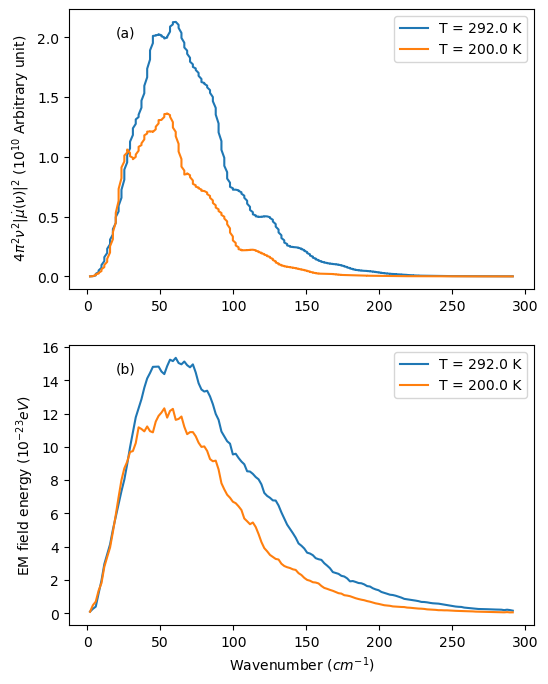

In [96]:
from copy import deepcopy

fig,ax = plt.subplots(2, figsize = (6,8))

for temp, freefield_result_dict in FREEFIELD_RESULT_DICT.items():
    
    k_list = np.sort(freefield_result_dict[0]['field'].k_val)
    wn_list = np.array(k_list * red.c)
    
    spec1 = dipole_spectra(freefield_result_dict, wavenumber = wn_list) * 1e-10
    
    wn_real = red.convert_wavenumber(k_list)
    w, s = pt.moving_average(wn_real, spec1, w = 10)
    ax[0].plot(w, s, label = "T = {} K".format(temp))
    
    omega_profile, rad_profile = field_spectra(freefield_result_dict, limit = 0) 
    rad_profile *= 1e23
    #ax[1].scatter(omega_profile, rad_profile, s = 5)
    o, f = pt.moving_average(omega_profile, rad_profile, w = 10)
    ax[1].plot(o, f, label = "T = {} K".format(temp))
    

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel(r" $4 \pi^2 \nu^2 |\dot{\mu}(\nu)|^2$ ($10^{10}$ Arbitrary unit)")
ax[1].set_ylabel(r"EM field energy ($10^{-23} eV$)")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")

ax[0].annotate('(a)',xy = (0.1,0.9), xycoords = 'axes fraction')
ax[1].annotate('(b)',xy = (0.1,0.9), xycoords = 'axes fraction')

fig.savefig(fig_root + "free_spectrum.jpeg",dpi = 600, bbox_inches = 'tight')

Text(0.5, 0, 'Wavenumber $(cm^{-1})$')

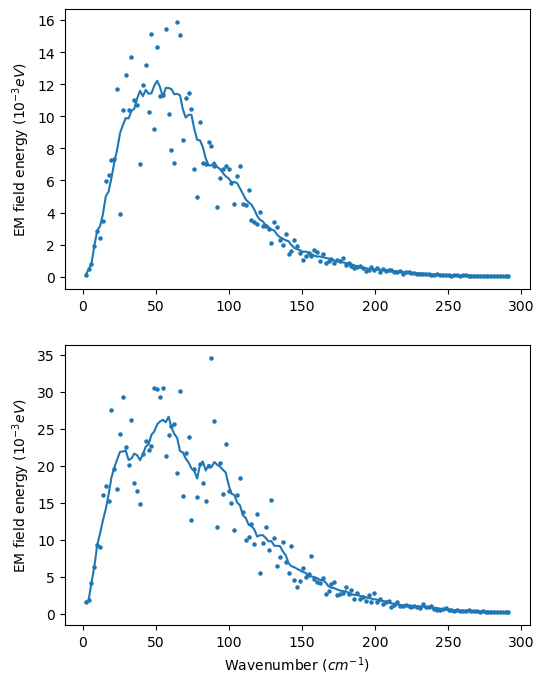

In [101]:
fig,ax = plt.subplots(2, figsize = (6,8))

"""
for temp, cavityfield_result_dict in CAVITYFIELD_RESULT_DICT1.items():
    
    omega_profile, rad_profile = field_spectra(cavityfield_result_dict, limit = 0) 
    #rad_profile *= 1e23
    #ax[1].scatter(omega_profile, rad_profile, s = 5)
    o, f = pt.moving_average(omega_profile, rad_profile, w = 10)
    ax[0].plot(o, f, label = "T = {}".format(temp))
"""
for i, (temp, cavityfield_result_dict) in enumerate(CAVITYFIELD_RESULT_DICT2.items()):
    
    omega_profile, rad_profile = field_spectra(cavityfield_result_dict, limit = 0) 
    rad_profile *= 1e3
    ax[i].scatter(omega_profile, rad_profile, s = 5)
    o, f = pt.moving_average(omega_profile, rad_profile, w = 10)
    ax[i].plot(o, f)#, label = "T = {}".format(temp))

ax[0].set_ylabel(r"EM field energy ($10^{-3} eV$)")
ax[1].set_ylabel(r"EM field energy ($10^{-3} eV$)")
ax[1].set_xlabel(r"Wavenumber $(cm^{-1})$")
#ax[1].legend()

In [102]:
def getall_colliding_time(result_dict, limit = None):
    all_colliding_time = np.array([])
    
    for i, rd in result_dict.items():
        if limit and i > limit: 
            continue
            
        atoms = rd['atoms']
        
        time = at.get_colliding_time(atoms, dipole_threshold = 0)
    
        all_colliding_time = np.hstack([all_colliding_time, time])
        
    return all_colliding_time

def longest_time(result_dict):
    longest_atom = None
    longest_time = 0 
    index = None
    
    for i, rd in result_dict.items():
            
        atoms = rd['atoms']
        
        time = at.get_colliding_time(atoms, dipole_threshold = 0)

        max_time = np.max(time)
        
        if max_time > longest_time:
            longest_time = max_time
            longest_atom = atoms
            index = np.argmax(time)

    print(longest_time)

    return (longest_atom, index)
    

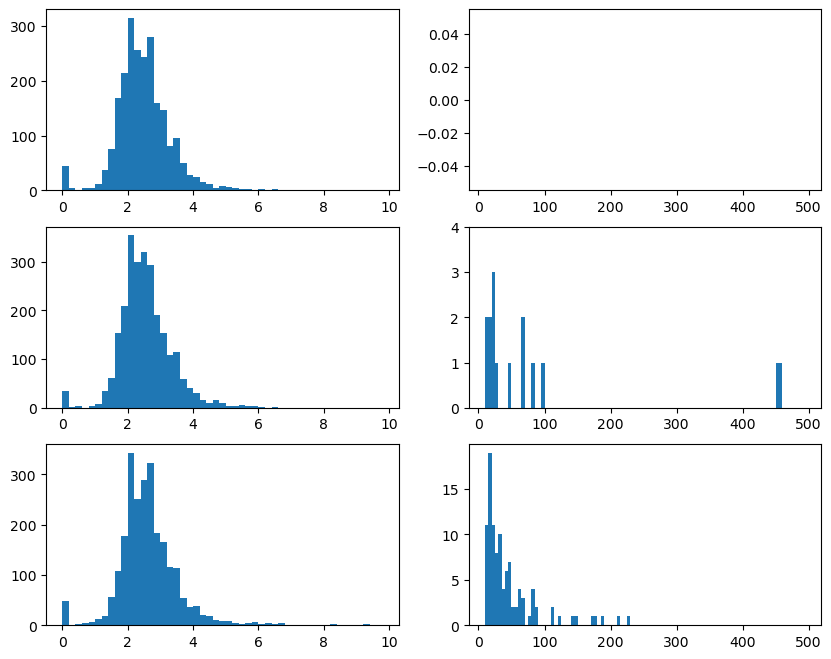

In [103]:
freefield_result_dict = FREEFIELD_RESULT_DICT['200.0']
cavityfield_result_dict = CAVITYFIELD_RESULT_DICT2['Lxy1e1']
cavityfield_result_dict1 = CAVITYFIELD_RESULT_DICT2['Lxy2e1']

ft = getall_colliding_time(freefield_result_dict, limit = 0)
ft = red.convert_time(ft)
ct1 = getall_colliding_time(cavityfield_result_dict, limit = 0)
ct1 = red.convert_time(ct1)
ct2 = getall_colliding_time(cavityfield_result_dict1, limit = 0)
ct2 = red.convert_time(ct2)

fig,ax = plt.subplots(3,2, figsize = (10,8))

hist1 = ax[0,0].hist(ft, np.arange(0,10,0.2))
hist2 = ax[1,0].hist(ct1, np.arange(0,10,0.2))
hist3 = ax[2,0].hist(ct2, np.arange(0,10,0.2))

hist1 = ax[0,1].hist(ft, np.arange(10,500,5))
hist2 = ax[1,1].hist(ct1, np.arange(10,500,5))
ax[1,1].set_ylim(0,4)
hist3 = ax[2,1].hist(ct2, np.arange(10,500,5))

#ax[2].scatter(bins_arr[:-1], hist1[0] - hist2[0])

In [104]:
atoms, i = longest_time(cavityfield_result_dict1)

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,i]
r_xe = np.array(atoms.trajectory['r'])[:,i + N_pairs]

v_ar = np.array(atoms.trajectory['r_dot'])[:,i]
v_xe = np.array(atoms.trajectory['r_dot'])[:,i + N_pairs]

t = np.array(atoms.trajectory['t'])

106.12247803845077


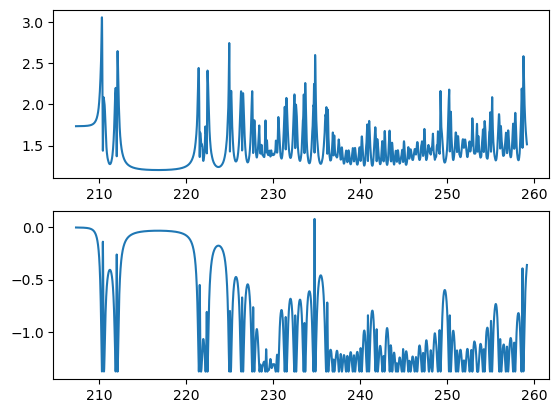

In [106]:
from calculator.function import LJ_potential

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)

fig,ax = plt.subplots(2)
ax[0].plot(t, k)
ax[1].plot(t, v)

In [ ]:
def calculate_impact_param(atoms):
    #first N_pairs atoms are Ar, last arre Xe
    N_pairs = int(len(atoms.r) / 2)

    d_ar_xe0 = - np.array(atoms.trajectory['r'][0][:N_pairs])
    d_ar_xe0 += np.array(atoms.trajectory['r'][0][N_pairs:])
    d_abs = np.sqrt(np.einsum("ni,ni->n", d_ar_xe0, d_ar_xe0))

    v_ar0 = np.array(atoms.trajectory['r_dot'][0][:N_pairs])
    v_ar0_abs = np.sqrt(np.einsum("ni,ni->n", v_ar0, v_ar0))

    dot = np.einsum("ni,ni->n", d_ar_xe0, v_ar0)
    angle = np.arccos(dot / (d_abs * v_ar0_abs))

    h = np.sin(angle) * d_abs

    return h

def calculate_def_angle(atoms):
    def angle(v1,v2):
        dot = np.einsum("ni,ni->n", v1,v2)
        v1_norm = np.sqrt(np.einsum("ni,ni->n",v1,v1))
        v2_norm = np.sqrt(np.einsum("ni,ni->n",v2,v2))
        angle = np.arccos(dot / (v1_norm * v2_norm))
        return angle * 360 / (2 * np.pi)
        
    N_pairs = int(len(atoms.r) / 2)

    v_ar_i = np.array(atoms.trajectory['r_dot'][0][:N_pairs])
    v_ar_f = np.array(atoms.trajectory['r_dot'][-1][:N_pairs])

    v_xe_i = np.array(atoms.trajectory['r_dot'][0][N_pairs:])
    v_xe_f = np.array(atoms.trajectory['r_dot'][-1][N_pairs:])

    return angle(v_ar_i,v_ar_f), angle(v_xe_i,v_xe_f)

fig,ax = plt.subplots(2,2)

all_defa_ar = []
all_defa_xe = []

for i, rd in freefield_result_dict.items():
    atoms = rd['atoms']

    ar_defangle, xe_defangle = calculate_def_angle(atoms) 

    all_defa_ar += list(ar_defangle)
    all_defa_xe += list(xe_defangle)

ax[0,0].hist(all_defa_ar, bins = np.arange(0, 180, 1) )
ax[0,1].hist(all_defa_xe, bins = np.arange(0, 180, 1) )

all_defa_ar = []
all_defa_xe = []

for i, rd in cavityfield_result_dict.items():
    atoms = rd['atoms']

    ar_defangle, xe_defangle = calculate_def_angle(atoms) 

    all_defa_ar += list(ar_defangle)
    all_defa_xe += list(xe_defangle)

ax[1,0].hist(all_defa_ar, bins = np.arange(0, 180, 1) )
ax[1,1].hist(all_defa_xe, bins = np.arange(0, 180, 1) )

In [ ]:
atoms = cavityfield_result_dict1[0]['atoms']
field = cavityfield_result_dict1[0]['field']

k = np.array(atoms.observable['kinetic'])
v = np.array(atoms.observable['potential'])

hrad = np.sum(field.history['energy'], axis = 1)
t = field.history['t']

total = k + v + hrad
print(total[0])
print(total[-1])

fig,ax = plt.subplots(2)

ax[0].plot(t, total)
ax[1].plot(t, hrad)